# Classifying WBC in Focus and out of Focus
This project aims at classifying WBC images into good WBC images and out of focus WBC images


## Define the imports

In [5]:
import tensorflow as tf

# Helper Function -- One hot encoding

In [6]:
def one_hot(x, numLabels):
    
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    # TODO: Implement Function
    
    onValue = 1
    offValue = 0
    output = tf.one_hot(x,numLabels, onValue, offValue)
    return output
    
    




In [22]:
# Labels must be starting from 0
def one_hot_numpy(x, numLabels):
    #print("X in one_hot_numpy",x)
    onValue = 1
    offValue = 0
    numImages = len(x)
    output = np.zeros((numImages, numLabels))
    output[np.arange(numImages), x] = 1
    return output
    
    


# Loading Data
This is used to load the data from disk.
The main data preparation including data augmentation and randomization was performed in Matlab
The cell assumes the location of the folder containing the images as well as a text file that has the image name and the label
The data is read and converted to tensos. 
Tensor X contains the image data
Tensor Y contains the corresponding labels in one hot encoding format

In [23]:
# Read the WBC data
import numpy as np
from scipy.misc import imread
from PIL import Image
from matplotlib import pyplot as plt
import glob
from IPython.display import Image, display
import pickle


# Define the basic info
Root = "E:\\Noha\\DeepLearningClass\\Project 2 -Image Classification\\WBC_5Part\\"
dimX = 51
dimY = 51
dimZ = 1

# read the image names and labels
infoFile = Root + "train_1.txt"              
with open(infoFile,"r") as f:
    imageList = [r.split()[0] for r in f]    
with open(infoFile,"r") as f:
    Labels = [r.split()[1] for r in f]
   
Labels = list(map(int, Labels))
#print (Labels) 

numLabels = 5
Labels = one_hot_numpy(Labels, numLabels)
print("One Hot Encoding Complete")
print(Labels[0])
numImages = len(imageList)
allImages = np.zeros((((numImages, dimX, dimY, dimZ))))

print("Total number of Images = ", numImages)

index = 0
for imageName in imageList:
    fileName = Root + imageName
    im = imread(fileName)
    im_3d = im.reshape(dimX,dimY,dimZ)
    allImages[index, :, :, :] = im_3d
    #plt.imshow(allImages[index,:,:,0], interpolation='nearest', cmap='gray')
    #plt.show()
    index = index + 1 
    
normalizedImages = normalize(allImages)
#X_Train = tf.convert_to_tensor(normalizedImages)
X_Train = normalizedImages
Y_Train = Labels

print(X_Train.shape)
print(Y_Train.shape)

## This part is used to read the testing data 
## To Do: This is redundant -- Either make it to function or use the partitioning functionalities in tensorflow

# read the image names and labels
infoFile = Root + "test.txt"              
with open(infoFile,"r") as f:
    imageList = [r.split()[0] for r in f]    
with open(infoFile,"r") as f:
    Labels = [r.split()[1] for r in f]
   
Labels = list(map(int, Labels))
#print (Labels) 

numLabels = 5
Labels = one_hot(Labels, numLabels)
numImages = len(imageList)
allImages = np.zeros((((numImages, dimX, dimY, dimZ))))

print("Total number of Images = ", numImages)

index = 0
for imageName in imageList:
    fileName = Root + imageName
    im = imread(fileName)
    im_3d = im.reshape(dimX,dimY,dimZ)
    allImages[index, :, :, :] = im_3d
    #plt.imshow(allImages[index,:,:,0], interpolation='nearest', cmap='gray')
    #plt.show()
    index = index + 1 
    
normalizedImages = normalize(allImages)
#X_Test = tf.convert_to_tensor(normalizedImages)
X_Test = normalizedImages
Y_Test = Labels

print(X_Test.shape)
print(Y_Test.shape)


## Save the prepared Data
#saveFileName = Root + "PreprocessedData.p"
#pickle.dump( (X, Y),  open(saveFileName,'wb'))



One Hot Encoding Complete
[ 1.  0.  0.  0.  0.]
Total number of Images =  240000
(240000, 51, 51, 1)
(240000, 5)
Total number of Images =  31949
(31949, 51, 51, 1)
(31949, 5)


## Divide the data into batches

In [50]:
batch_size = 1000
min_after_dequeue = 10000
capacity = min_after_dequeue + 3 * batch_size
image_batch, label_batch = tf.train.batch([X_Train,Y_Train], batch_size = 1 )
print("*******")
print(X_Test)
image_test_batch, label_test_batch = tf.train.shuffle_batch([X_Test, Y_Test], batch_size = batch_size, capacity = capacity, min_after_dequeue = min_after_dequeue)

print(image_test_batch[0])


*******
Tensor("Const_1:0", shape=(31949, 51, 51, 1), dtype=float64)
Tensor("strided_slice_6:0", shape=(31949, 51, 51, 1), dtype=float64)


## Implement Preprocess Functions
### Normalize
In the cell below, implement the `normalize` function to take in image data, `x`, and return it as a normalized Numpy array. The values should be in the range of 0 to 1, inclusive.  The return object should be the same shape as `x`.

In [17]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    # find the dimensions of the input sample

    [numImages, dimX, dimY, dimZ] = x.shape
    normalizedImage = np.zeros(((dimX,dimY,dimZ)))
    output = np.zeros((((numImages, dimX, dimY, dimZ))))
    
    for image in range (0,numImages):
        currentImage = x[image,:,:,:]
        # normalizing each channel by subtracting the min (0) and dividing by the max to return values between 0 and 1
        normalizedImage = currentImage/255
        output[image, :,:,:] = normalizedImage
        
    
    # TODO: Implement Function
    #x = (x-x.min())/(x.max()-x.min())
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
#tests.test_normalize(normalize)

"\nDON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE\n"

### Randomize Data
As you saw from exploring the data above, the order of the samples are randomized.  It doesn't hurt to randomize it again, but you don't need to for this dataset.

## Preprocess all the data and save it
Running the code cell below will preprocess all the CIFAR-10 data and save it to file. The code below also uses 10% of the training data for validation.

In [45]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

# Check Point
This is your first checkpoint.  If you ever decide to come back to this notebook or have to restart the notebook, you can start from here.  The preprocessed data has been saved to disk.

In [46]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle
import problem_unittests as tests
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Build the network
For the neural network, you'll build each layer into a function.  Most of the code you've seen has been outside of functions. To test your code more thoroughly, we require that you put each layer in a function.  This allows us to give you better feedback and test for simple mistakes using our unittests before you submit your project.

>**Note:** If you're finding it hard to dedicate enough time for this course each week, we've provided a small shortcut to this part of the project. In the next couple of problems, you'll have the option to use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages to build each layer, except the layers you build in the "Convolutional and Max Pooling Layer" section.  TF Layers is similar to Keras's and TFLearn's abstraction to layers, so it's easy to pickup.

>However, if you would like to get the most out of this course, try to solve all the problems _without_ using anything from the TF Layers packages. You **can** still use classes from other packages that happen to have the same name as ones you find in TF Layers! For example, instead of using the TF Layers version of the `conv2d` class, [tf.layers.conv2d](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d), you would want to use the TF Neural Network version of `conv2d`, [tf.nn.conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d). 

Let's begin!

### Input
The neural network needs to read the image data, one-hot encoded labels, and dropout keep probability. Implement the following functions
* Implement `neural_net_image_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Set the shape using `image_shape` with batch size set to `None`.
 * Name the TensorFlow placeholder "x" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
* Implement `neural_net_label_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Set the shape using `n_classes` with batch size set to `None`.
 * Name the TensorFlow placeholder "y" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
* Implement `neural_net_keep_prob_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder) for dropout keep probability.
 * Name the TensorFlow placeholder "keep_prob" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).

These names will be used at the end of the project to load your saved model.

Note: `None` for shapes in TensorFlow allow for a dynamic size.

In [24]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    # TODO: Implement Function
    dimX = image_shape[0]
    dimY = image_shape[1]
    dimZ = image_shape[2]

    x = tf.placeholder(tf.float32, shape=(None, dimX, dimY, dimZ), name ='x')
    return x


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    # TODO: Implement Function
    y = tf.placeholder(tf.int16, shape=(None, n_classes), name = 'y')
    return y


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    # TODO: Implement Function
    keep_prob = tf.placeholder(tf.float32, name ='keep_prob')
    return keep_prob


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
#tf.reset_default_graph()
#tests.test_nn_image_inputs(neural_net_image_input)
#tests.test_nn_label_inputs(neural_net_label_input)
#tests.test_nn_keep_prob_inputs(neural_net_keep_prob_input)

"\nDON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE\n"

### Convolution and Max Pooling Layer
Convolution layers have a lot of success with images. For this code cell, you should implement the function `conv2d_maxpool` to apply convolution then max pooling:
* Create the weight and bias using `conv_ksize`, `conv_num_outputs` and the shape of `x_tensor`.
* Apply a convolution to `x_tensor` using weight and `conv_strides`.
 * We recommend you use same padding, but you're welcome to use any padding.
* Add bias
* Add a nonlinear activation to the convolution.
* Apply Max Pooling using `pool_ksize` and `pool_strides`.
 * We recommend you use same padding, but you're welcome to use any padding.

**Note:** You **can't** use [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) for **this** layer, but you can still use TensorFlow's [Neural Network](https://www.tensorflow.org/api_docs/python/tf/nn) package. You may still use the shortcut option for all the **other** layers.

In [25]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    
    # TODO: Implement Function

    
    dims = x_tensor.get_shape().as_list()
    
    F_W = tf.Variable(tf.truncated_normal([dims[1], dims[2], dims[3], conv_num_outputs ], mean = 0.0, stddev = 0.05, dtype = tf.float32, seed = None, name = "F_W"))
    F_b = tf.Variable(tf.random_normal([conv_num_outputs]), name = "F_b")
    
    strides = [1, conv_strides[0], conv_strides[1], 1]
    conv = tf.nn.conv2d(x_tensor, F_W, strides, padding="SAME")
    Relu_Input = tf.nn.bias_add(conv,F_b)
    convOutput = tf.nn.relu(Relu_Input)
 
    
    #Implement max pooling
    
    k_size = [1, pool_ksize[0], pool_ksize[1], 1]
    k_strides = [1, pool_strides[0], pool_strides[1], 1]
    output = tf.nn.max_pool(convOutput, k_size, k_strides, padding ="SAME")              
    return output 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
#tests.test_con_pool(conv2d_maxpool)

"\nDON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE\n"

### Flatten Layer
Implement the `flatten` function to change the dimension of `x_tensor` from a 4-D tensor to a 2-D tensor.  The output should be the shape (*Batch Size*, *Flattened Image Size*). Shortcut option: you can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer. For more of a challenge, only use other TensorFlow packages.

In [26]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    # TODO: Implement Function

    shape = x_tensor.get_shape().as_list()        # a list: [None, 9, 2]
    dim = np.prod(shape[1:])
    oo = tf.reshape(x_tensor,[-1,dim])
    return oo


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
#tests.test_flatten(flatten)

"\nDON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE\n"

### Fully-Connected Layer
Implement the `fully_conn` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*). Shortcut option: you can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer. For more of a challenge, only use other TensorFlow packages.

In [27]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function

    W = tf.Variable(tf.truncated_normal([int(x_tensor.shape[1]), num_outputs], mean=0.0, stddev=0.05, dtype = tf.float32, seed=None, name = None))
    b = tf.Variable(tf.random_normal([num_outputs]))
    fc1 = tf.add(tf.matmul(x_tensor, W), b)
    fc1 = tf.nn.relu(fc1)
    return fc1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
#tests.test_fully_conn(fully_conn)

"\nDON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE\n"

### Output Layer
Implement the `output` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*). Shortcut option: you can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer. For more of a challenge, only use other TensorFlow packages.

**Note:** Activation, softmax, or cross entropy should **not** be applied to this.

In [28]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    
    ## Weight dimensions = # outputs of the inputs
    dims = x_tensor.get_shape().as_list() 
    W = tf.Variable(tf.truncated_normal([dims[1], num_outputs], mean=0.0, stddev=0.05, dtype = tf.float32, seed=None, name = None))
    b = tf.Variable(tf.random_normal([num_outputs]))
    output = tf.add(tf.matmul(x_tensor,W), b)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
#tests.test_output(output)

"\nDON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE\n"

### Create Convolutional Model
Implement the function `conv_net` to create a convolutional neural network model. The function takes in a batch of images, `x`, and outputs logits.  Use the layers you created above to create this model:

* Apply 1, 2, or 3 Convolution and Max Pool layers
* Apply a Flatten Layer
* Apply 1, 2, or 3 Fully Connected Layers
* Apply an Output Layer
* Return the output
* Apply [TensorFlow's Dropout](https://www.tensorflow.org/api_docs/python/tf/nn/dropout) to one or more layers in the model using `keep_prob`. 

In [38]:
import problem_unittests as tests
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    # TODO: Apply 1, 2, or 3 Convolution and Max Pool layers
    #    Play around with different number of outputs, kernel size and stride
    # Function Definition from Above:
    #    conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    
    dims = x.shape;

    # First convolutional layer
    conv_num_outputs = 50 
    print(dims)
    print(conv_num_outputs)
    conv_ksize = (5,5)
    conv_strides = (3,3)
    pool_ksize = (4,4)
    pool_strides = (2,2)
    Conv_MaxPool_1 = conv2d_maxpool(x, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)

    # Second convolutional layer
    conv_num_outputs = 200 #dims[0]/3
    conv_ksize = (3,3)
    conv_strides = (1,1)
    pool_ksize = (2,2)
    pool_strides = (1,1)
    Conv_MaxPool_2 = conv2d_maxpool(Conv_MaxPool_1, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)

    # Adding a drop out
    #MaxPool2_DO = tf.nn.dropout(Conv_MaxPool_2,0.6)

    # Third convolutional layer
    #conv_num_outputs = 60
    #conv_ksize = (2,2)
    #conv_strides = (1,1)
    #pool_ksize = (2,2)
    #pool_strides = (1,1)
    #Conv_MaxPool_3 = conv2d_maxpool(Conv_MaxPool_2, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    
    # TODO: Apply a Flatten Layer
    # Function Definition from Above:
    #   flatten(x_tensor) 
    DO = tf.nn.dropout(Conv_MaxPool_2,0.7)
    Flat = flatten(DO)
    
    FC = fully_conn(Flat, 128)
    FC1 = fully_conn(FC, 50)

    Output = output(FC1,10)
    return Output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
##############tf.reset_default_graph()

# Inputs
x = neural_net_image_input((51, 51, 1))
y = neural_net_label_input(5)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

#tests.test_conv_net(conv_net)

(?, 51, 51, 1)
50


# Define the cost function

## Train the Neural Network
### Single Optimization
Implement the function `train_neural_network` to do a single optimization.  The optimization should use `optimizer` to optimize in `session` with a `feed_dict` of the following:
* `x` for image input
* `y` for labels
* `keep_prob` for keep probability for dropout

This function will be called for each batch, so `tf.global_variables_initializer()` has already been called.

Note: Nothing needs to be returned. This function is only optimizing the neural network.

In [30]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    session.run(optimizer, feed_dict={x: feature_batch, y:label_batch, keep_prob: keep_probability})
              
    pass


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
#tests.test_train_nn(train_neural_network)

"\nDON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE\n"

### Show Stats
Implement the function `print_stats` to print loss and validation accuracy.  Use the global variables `valid_features` and `valid_labels` to calculate validation accuracy.  Use a keep probability of `1.0` to calculate the loss and validation accuracy.

In [31]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    # TODO: Implement Function

    current_cost = session.run(cost, feed_dict={x: feature_batch, y: label_batch})
    valid_accuracy = session.run(accuracy, feed_dict={x: valid_features, y: valid_labels, keep_prob: 1.0})
    print(current_cost)
    print(valid_accuracy)
    
    pass



### Hyperparameters
Tune the following parameters:
* Set `epochs` to the number of iterations until the network stops learning or start overfitting
* Set `batch_size` to the highest number that your machine has memory for.  Most people set them to common sizes of memory:
 * 64
 * 128
 * 256
 * ...
* Set `keep_probability` to the probability of keeping a node using dropout

In [32]:
# TODO: Tune Parameters
epochs = 100
batch_size = 1000
keep_probability = 0.8

### Train on a Single CIFAR-10 Batch
Instead of training the neural network on all the CIFAR-10 batches of data, let's use a single batch. This should save time while you iterate on the model to get a better accuracy.  Once the final validation accuracy is 50% or greater, run the model on all the data in the next section.

In [46]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    numExamples = len(X_Train)
    print(numExamples)
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        #for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
        #for batch_features, batch_labels in ([image_test_batch, label_test_batch],batch_size):
        #    features = batch_features.eval()
        #    train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print(X_Train.dtype)
        print(Y_Train.dtype)
        X_Train = X_Train.astype(np.float32)
        Y_Train = Y_Train.astype(np.int16)
        print(X_Train.dtype)
        print(Y_Train.dtype)
        for offset in range(0, numExamples, batch_size):
            end = offset + batch_size
            batch_x, batch_y = X_Train[offset:end], Y_Train[offset:end]
            train_neural_network(sess, optimizer, keep_probability, batch_x, batch_y)
        
        
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
240000
float64
float64
float32
int16


InvalidArgumentError: logits and labels must be same size: logits_size=[1000,10] labels_size=[1000,5]
	 [[Node: SoftmaxCrossEntropyWithLogits_2 = SoftmaxCrossEntropyWithLogits[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](Reshape_11, Reshape_12)]]

Caused by op 'SoftmaxCrossEntropyWithLogits_2', defined at:
  File "C:\Users\el-zno00\AppData\Local\Continuum\Anaconda3\envs\dlnd-tf-lab\lib\runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\el-zno00\AppData\Local\Continuum\Anaconda3\envs\dlnd-tf-lab\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\el-zno00\AppData\Local\Continuum\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\Users\el-zno00\AppData\Local\Continuum\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\el-zno00\AppData\Local\Continuum\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\ipykernel\kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\el-zno00\AppData\Local\Continuum\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\el-zno00\AppData\Local\Continuum\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\tornado\ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "C:\Users\el-zno00\AppData\Local\Continuum\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\el-zno00\AppData\Local\Continuum\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\el-zno00\AppData\Local\Continuum\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\el-zno00\AppData\Local\Continuum\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\el-zno00\AppData\Local\Continuum\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\el-zno00\AppData\Local\Continuum\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\ipykernel\kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\el-zno00\AppData\Local\Continuum\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\ipykernel\kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\el-zno00\AppData\Local\Continuum\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\ipykernel\kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\el-zno00\AppData\Local\Continuum\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\el-zno00\AppData\Local\Continuum\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\ipykernel\zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\el-zno00\AppData\Local\Continuum\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\el-zno00\AppData\Local\Continuum\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\IPython\core\interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\el-zno00\AppData\Local\Continuum\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-38-131680243cef>", line 103, in <module>
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
  File "C:\Users\el-zno00\AppData\Local\Continuum\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 1617, in softmax_cross_entropy_with_logits
    precise_logits, labels, name=name)
  File "C:\Users\el-zno00\AppData\Local\Continuum\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 2265, in _softmax_cross_entropy_with_logits
    features=features, labels=labels, name=name)
  File "C:\Users\el-zno00\AppData\Local\Continuum\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "C:\Users\el-zno00\AppData\Local\Continuum\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\tensorflow\python\framework\ops.py", line 2395, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\el-zno00\AppData\Local\Continuum\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\tensorflow\python\framework\ops.py", line 1264, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): logits and labels must be same size: logits_size=[1000,10] labels_size=[1000,5]
	 [[Node: SoftmaxCrossEntropyWithLogits_2 = SoftmaxCrossEntropyWithLogits[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](Reshape_11, Reshape_12)]]


### Fully Train the Model
Now that you got a good accuracy with a single CIFAR-10 batch, try it with all five batches.

In [74]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  2.27204
0.1354
Epoch  1, CIFAR-10 Batch 2:  2.11998
0.218
Epoch  1, CIFAR-10 Batch 3:  2.03429
0.2494
Epoch  1, CIFAR-10 Batch 4:  1.9563
0.2608
Epoch  1, CIFAR-10 Batch 5:  1.92095
0.2866
Epoch  2, CIFAR-10 Batch 1:  1.90095
0.3006
Epoch  2, CIFAR-10 Batch 2:  1.85944
0.3206
Epoch  2, CIFAR-10 Batch 3:  1.77799
0.3516
Epoch  2, CIFAR-10 Batch 4:  1.75603
0.3474
Epoch  2, CIFAR-10 Batch 5:  1.76121
0.3684
Epoch  3, CIFAR-10 Batch 1:  1.71812
0.3758
Epoch  3, CIFAR-10 Batch 2:  1.69421
0.3826
Epoch  3, CIFAR-10 Batch 3:  1.65018
0.3724
Epoch  3, CIFAR-10 Batch 4:  1.6415
0.3876
Epoch  3, CIFAR-10 Batch 5:  1.62386
0.4124
Epoch  4, CIFAR-10 Batch 1:  1.57119
0.418
Epoch  4, CIFAR-10 Batch 2:  1.5813
0.4268
Epoch  4, CIFAR-10 Batch 3:  1.51837
0.4272
Epoch  4, CIFAR-10 Batch 4:  1.52269
0.4362
Epoch  4, CIFAR-10 Batch 5:  1.52476
0.4442
Epoch  5, CIFAR-10 Batch 1:  1.52051
0.4396
Epoch  5, CIFAR-10 Batch 2:  1.48578
0.461
Epoch  5, CIFAR-10 Batch 3

# Checkpoint
The model has been saved to disk.
## Test Model
Test your model against the test dataset.  This will be your final accuracy. You should have an accuracy greater than 50%. If you don't, keep tweaking the model architecture and parameters.

Testing Accuracy: 0.5651999950408936



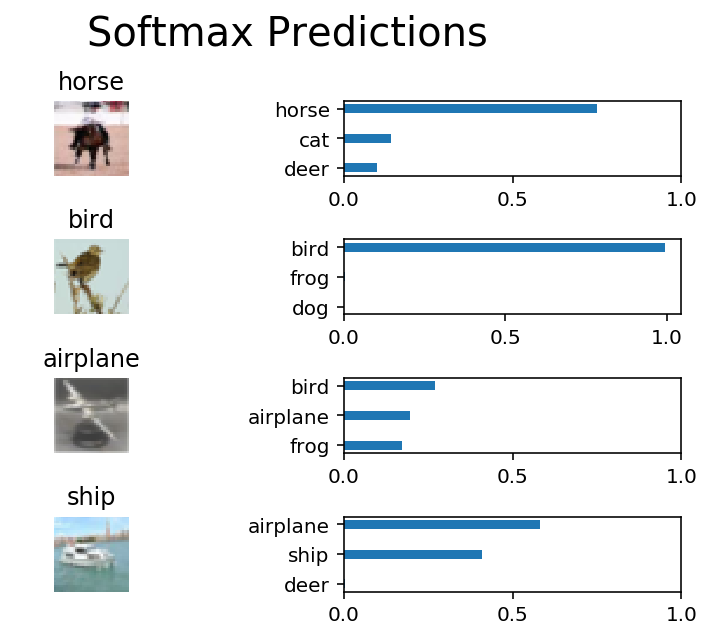

In [75]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()

## Why 50-80% Accuracy?
You might be wondering why you can't get an accuracy any higher. First things first, 50% isn't bad for a simple CNN.  Pure guessing would get you 10% accuracy. However, you might notice people are getting scores [well above 80%](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130).  That's because we haven't taught you all there is to know about neural networks. We still need to cover a few more techniques.
## Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook.  Save the notebook file as "dlnd_image_classification.ipynb" and save it as a HTML file under "File" -> "Download as".  Include the "helper.py" and "problem_unittests.py" files in your submission.